## Prepare X_train, X_val, y_train, y_val

In [1]:
import LoadAndPreprocessDataset

In [2]:
#Load filenames
train,val,test = LoadAndPreprocessDataset.loadDatasetFilenames()

#Load TRAIN files
X,y_train=LoadAndPreprocessDataset.loadBatch(train,batch_size=1000)
#Preprocess TRAIN
X_train=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_train=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#Release memory
del(X)

#Load VAL files
X,y_val=LoadAndPreprocessDataset.loadBatch(val,batch_size=100)
#Preprocess VAL
X_val=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_val=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#Release memory
del(X)

print(X_train.shape,X_val.shape)

#ADD extra dimension for CNN
import numpy as np
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
print(X_train.shape,X_val.shape)

# NORMALIZATION
### NO normalization seems better
#from sklearn.preprocessing import normalize
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1,1)) # Gives huge bias
#for i in range(len(X_train)):
    #X_train[i]=normalize(X_train[i], axis=0, norm='max') #normalize each feature of the example
    #X_train[i]=(X_train[i] - X_train[i].min(0)) / X_train[i].ptp(0) # HUGE BIAS
    #X_train[i]=scaler.fit_transform(X_train[i]) # HUGE BIAS
#for i in range(len(X_val)):
    #X_val[i]=normalize(X_val[i], axis=0, norm='max') #normalize each feature of the example
    #X_val[i]=(X_val[i] - X_val[i].min(0)) / X_val[i].ptp(0) #HUGE BIAS
    #X_val[i]=scaler.fit_transform(X_val[i])  # HUGE BIAS




(1000, 120, 126) (100, 120, 126)
(1000, 120, 126, 1) (100, 120, 126, 1)


(1000, 120, 126, 1)
(1000,)
(100, 120, 126, 1)
(100,)


ValueError: too many values to unpack (expected 2)

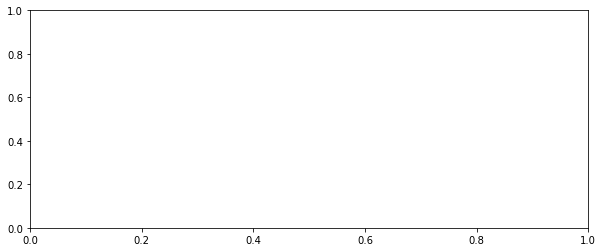

In [3]:
# Look at some data

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.pcolormesh(X_train[0])
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(X_val[0])
plt.show()

import numpy as np
print(np.min(X_train))
print(np.max(X_train))

for i in range(len(X_train[1])):
    print(i,np.min(X_train[1,i]),np.max(X_train[1,i]))
print(X_train[1].shape)

## Define NN

In [4]:
import Models

In [5]:
categories=['yes','no','up','down','left','right','on','off','stop','go']
nCategories=len(categories)


modelName="simpleCNN-elu"
model = Models.SimpleCNN(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)



model.compile(optimizer='Nadam',
              loss=['sparse_categorical_crossentropy'],
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "simpleCNN-elu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 63, 16)        65552     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 32, 16)        65552     
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                153610    
Total params: 284,714
Trainable params: 284,714
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
import math
import datetime

log_dir = "logs/fit/" +modelName+"-"+ datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

def performance_scheduling(epoch):
    #.....
    return lrate

my_callbacks = [
    EarlyStopping(monitor='val_sparse_categorical_accuracy',
                  patience=15,
                  verbose=1,
                  restore_best_weights=True),
    ModelCheckpoint('models/'+modelName+'.h5',
                    monitor='val_sparse_categorical_accuracy',
                    verbose=1,
                    save_best_only=True)]#,
    #lrate]


In [8]:
#Train
results = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val,y_val),
                    batch_size=32, # usually between 10 and 32
                    epochs=60,
                    callbacks=my_callbacks,
                    verbose=1)

#model.save('models/'+modelName+'.h5')

Train on 1000 samples, validate on 100 samples
Epoch 1/60
 992/1000 [============================>.] - ETA: 0s - loss: 7.4312 - sparse_categorical_accuracy: 0.1310
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.10000, saving model to models/simpleCNN-elu.h5
1000/1000 [==============================] - 6s 6ms/sample - loss: 7.4025 - sparse_categorical_accuracy: 0.1300 - val_loss: 3.2638 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/60
 992/1000 [============================>.] - ETA: 0s - loss: 2.1039 - sparse_categorical_accuracy: 0.3387
Epoch 00002: val_sparse_categorical_accuracy improved from 0.10000 to 0.15000, saving model to models/simpleCNN-elu.h5
1000/1000 [==============================] - 3s 3ms/sample - loss: 2.1060 - sparse_categorical_accuracy: 0.3380 - val_loss: 5.3796 - val_sparse_categorical_accuracy: 0.1500
Epoch 3/60
 992/1000 [============================>.] - ETA: 0s - loss: 1.4659 - sparse_categorical_accuracy: 0.5685
Epoch 00003: val_spar

 992/1000 [============================>.] - ETA: 0s - loss: 0.0013 - sparse_categorical_accuracy: 1.0000
Epoch 00022: val_sparse_categorical_accuracy did not improve from 0.46000
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0012 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.2604 - val_sparse_categorical_accuracy: 0.4500
Epoch 23/60
 992/1000 [============================>.] - ETA: 0s - loss: 0.0011 - sparse_categorical_accuracy: 1.0000
Epoch 00023: val_sparse_categorical_accuracy did not improve from 0.46000
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.2834 - val_sparse_categorical_accuracy: 0.4500
Epoch 24/60
 992/1000 [============================>.] - ETA: 0s - loss: 0.0011 - sparse_categorical_accuracy: 1.0000
Epoch 00024: val_sparse_categorical_accuracy did not improve from 0.46000
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0011 - sparse_categor

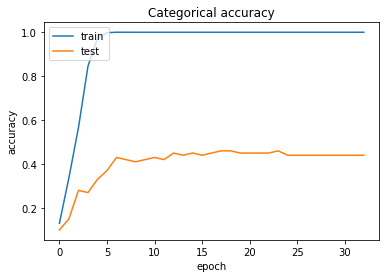

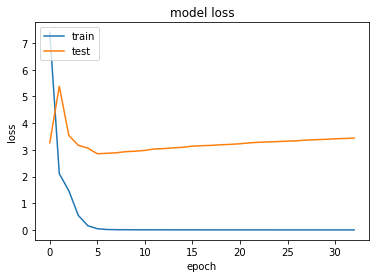

In [13]:
import matplotlib.pyplot as plt

import datetime
save_dir="output/"+modelName+"-"+ datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_"

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Categorical Accuracy", dpi=400)
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Loss", dpi=400)
plt.show()



## Test the model

In [10]:
#Load TEST files
X,y_test=LoadAndPreprocessDataset.loadBatch(val,batch_size=1000)
#Preprocess TEST
X_test=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_test=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#Release memory
del(X)

#ADD extra dimension for CNN
import numpy as np
X_test = X_test[..., np.newaxis]

In [11]:
#load best model
from tensorflow.keras.models import load_model
model = load_model('models/'+modelName+'.h5')

# Test the model on test data
import numpy as np
score = model.evaluate(X_test, y_test)
y_pred=np.argmax(model.predict(X_test),1)


#Measure time for every single prediction
"""import time

s=time.time()
y_pred=np.argmax(model.predict(X_test[:500,:,:]),1)
e=time.time()
print("Entire:",e-s)

starts=np.empty((len(X_test),))
ends=np.empty((len(X_test),))
for i in range(len(X_test)):
    a=np.array([X_test[i]])
    starts[i]=time.time()
    a=np.argmax(model.predict(a),1)
    ends[i]=time.time()
average=sum(ends-starts)/len(X_test)
print("Average single prediction time (s):",average)"""

# 1 prediction or a batch of 10 requires the same amount of time
# a batch of 100 prediction requires the double of 1
# a batch of 500 prediction requires the 3 times of 1

1000/1000 [==============================] - 2s 2ms/sample - loss: 3.1897 - sparse_categorical_accuracy: 0.3770


'import time\n\ns=time.time()\ny_pred=np.argmax(model.predict(X_test[:500,:,:]),1)\ne=time.time()\nprint("Entire:",e-s)\n\nstarts=np.empty((len(X_test),))\nends=np.empty((len(X_test),))\nfor i in range(len(X_test)):\n    a=np.array([X_test[i]])\n    starts[i]=time.time()\n    a=np.argmax(model.predict(a),1)\n    ends[i]=time.time()\naverage=sum(ends-starts)/len(X_test)\nprint("Average single prediction time (s):",average)'

## Metrics Summary

Train loss:	 0.0005819081799127161
Train accuracy:	 1.0
Val loss:	 3.437861261367798
Val accuracy:	 0.4399999976158142
Test loss:	 3.1897080726623535
Test accuracy:	 0.377
Bias:		 -0.01
Variance:	 0.5600000023841858
Precision:	 0.377
Recall:		 0.377
F1:		 0.377


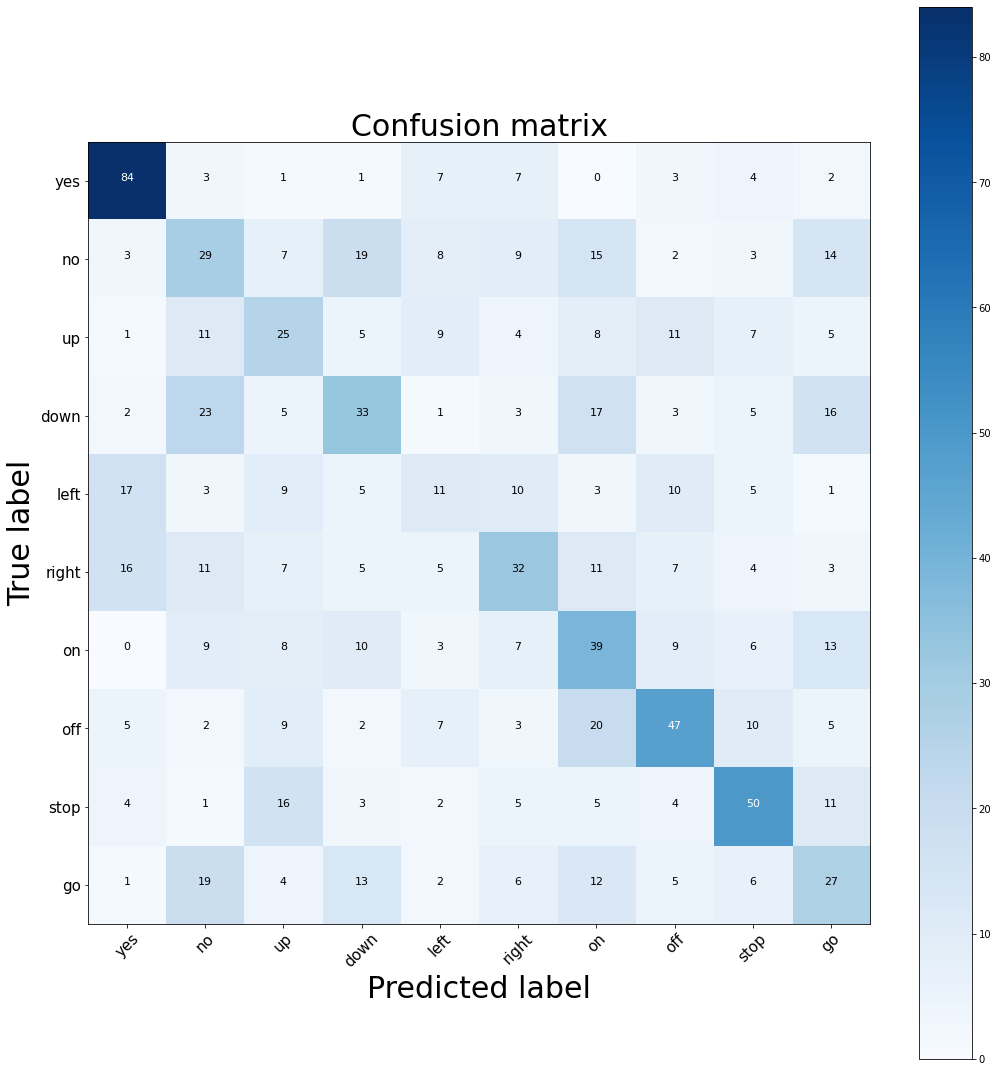

In [14]:
train_loss=results.history.get('loss')[-1]
val_loss=results.history.get('val_loss')[-1]

train_error=1-results.history.get('sparse_categorical_accuracy')[-1]
val_error=1-results.history.get('val_sparse_categorical_accuracy')[-1]

test_loss=score[0]
test_error=1-score[1]

print('Train loss:\t', train_loss)
print('Train accuracy:\t', 1-train_error)
print('Val loss:\t', val_loss)
print('Val accuracy:\t', 1-val_error)
print('Test loss:\t', test_loss)
print('Test accuracy:\t', score[1])

optimal_error=0.01 #human error

bias=train_error-optimal_error
variance=val_error-train_error
print("Bias:\t\t",bias)
print("Variance:\t",variance)


# Precision and Recall(sensitivity/true positive rate)
from sklearn.metrics import precision_score, recall_score
prec=precision_score(y_test, y_pred,average='micro')
rec=recall_score(y_test, y_pred,average='micro')

#F1 - high if both recall and precision are high.
from sklearn.metrics import f1_score
f1=f1_score(y_test, y_pred,average='micro')

print("Precision:\t",prec)
print("Recall:\t\t",rec)
print("F1:\t\t",f1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
import audioUtils
audioUtils.plot_confusion_matrix(cm,categories, normalize=False,save_path=save_dir)



# SAVE METRICS TO FILE
f = open(save_dir+"Metrics.txt", "a")
f.write('Train loss:\t'+ str(train_loss)+ "\n")
f.write('Train accuracy:\t'+ str((1-train_error))+ "\n")
f.write('Val loss:\t'+ str(val_loss)+ "\n")
f.write('Val accuracy:\t'+ str((1-val_error))+ "\n")
f.write('Test loss:\t'+ str(test_loss)+ "\n")
f.write('Test accuracy:\t'+ str(score[1])+ "\n")
f.write("Bias:\t\t"+str(bias)+ "\n")
f.write("Variance:\t"+str(variance)+ "\n")
f.write("Precision:\t"+str(prec)+ "\n")
f.write("Recall:\t\t"+str(rec)+ "\n")
f.write("F1:\t\t"+str(f1))
f.close()

In [ ]:
#ROC FOR MULTICLASS?????
"""
#ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # dashed diagonal
    # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()

#AUC Score
#perfect classifier=1, purely random=0.5.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)"""